<a href="https://colab.research.google.com/github/IT21388934/DL_LAB08/blob/main/Markov_Decision_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Decision Process (MDP)

### Rumesh Siriwardhana

In [ ]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [ ]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [ ]:
class MDP():
    def _init_(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

        # Add terminal states
        if 'terminal_states' in mdp_dict:
            self.terminal_states = mdp_dict['terminal_states']  # List of terminal states
        else:


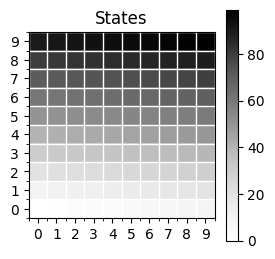

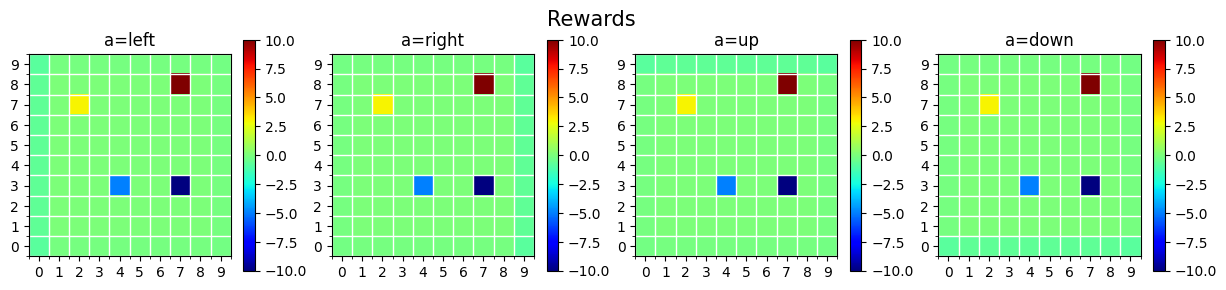

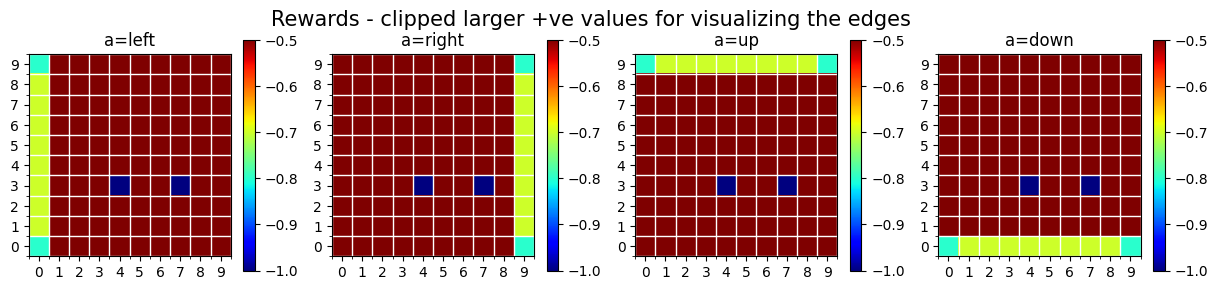

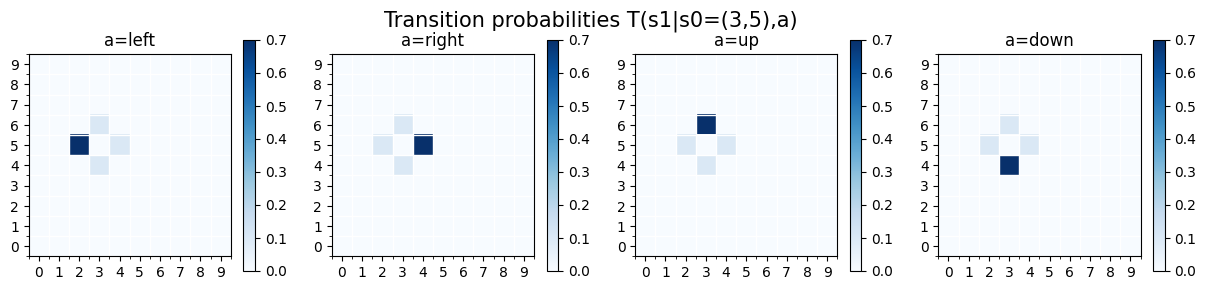

In [ ]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [ ]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

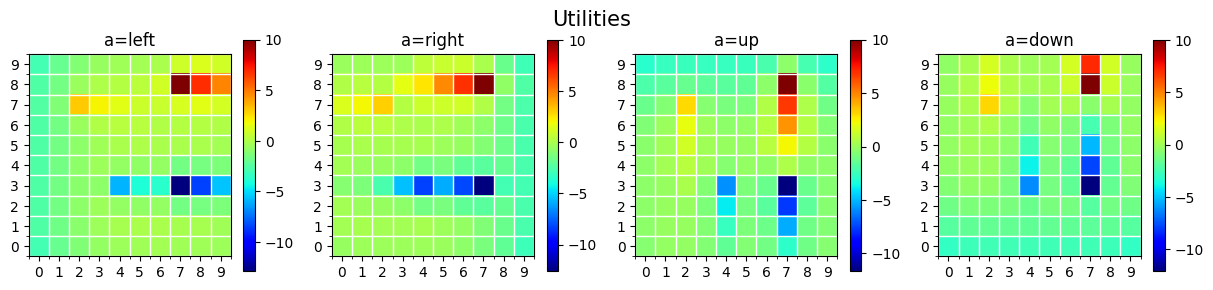

In [ ]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))  # Initialize utilities to zero for all states
    gamma = mdp.discount  # Discount factor
    U_old = copy.copy(U)

    for t in range(numIterations):
      #type your code here
        U_old = copy.copy(U)  # Keep a copy of old utilities
        for s in mdp.S:  # For each state in the state space
            action = policy[s]  # Get the action based on the policy
            R = mdp.R[s, action]  # Access reward for state-action pair
            T = mdp.T[s, action]  # Access transition probabilities for state-action pair

            # Update utility for state s
            U[s] = R + gamma * sum(T[s_prime] * U_old[s_prime] for s_prime in mdp.S)

    return U

# Set number of iterations and plotting utilities
numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)

for a in range(4):  # Iterate over different actions
    policy = {s: a for s in mdp.S}  # Create a simple policy that assigns action 'a' to all states
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=policy, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')

pl.show()

#print(np.round(U.reshape(10,10),3))

In [ ]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

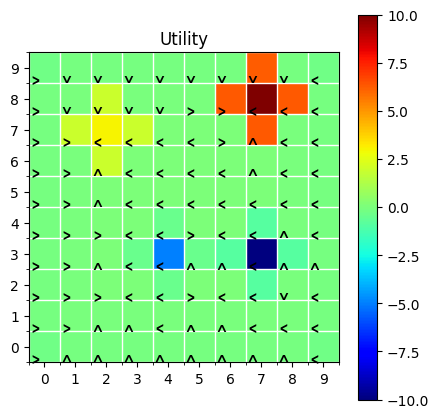

In [ ]:
# Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))  # Initialize utility values
    U_old = copy.copy(U)  # Keep a copy of the old utility values
    for t in range(numIterations):
        for s0 in range(len(mdp.S)):
            U[s0] = max([mdp.R[s0, a] + mdp.discount * np.sum(mdp.T[s0, a, :] * U_old[:]) for a in np.arange(len(mdp.A))])
        U_old = copy.copy(U)
    return U

# Policy extraction
def policyExtraction(mdp, U):
    policy = np.zeros(len(mdp.S))
    for s0 in range(len(mdp.S)):
        policy[s0] = np.argmax([mdp.R[s0, a] + mdp.discount * np.sum(mdp.T[s0, a, :] * U[:]) for a in np.arange(len(mdp.A))])
    return policy

# Perform value iteration and extract the policy
U = valueIteration(mdp, numIterations=2)
policy = policyExtraction(mdp, U=U)

# Plotting the utility and policy
pl.figure(figsize=(5, 5))  # Increased size for better visibility
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10, 10), title='Utility', cmap='jet')

# Define the arrow symbols for the policy directions
policy_markers = ['\u02C2', '\u02C3', '\u02C4', '\u02C5']  # Left, right, up, down arrows

# Add policy arrows to the plot
for s in range(len(mdp.S)):
    x, y = mdp.s2xy(s)
    m = policy_markers[int(policy[s])]  # Get the correct arrow based on the policy
    pl.text(x - 0.5, y - 1, m, color='k', size=20)

pl.show()

In [ ]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)

    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [ ]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S))  # Initial utility values
    pi_k = np.random.randint(low=0, high=4, size=len(mdp.S), dtype=int)  # Initial random policy
    pi_kp1 = copy.copy(pi_k)

    for t in range(numIterations):
        # Policy Evaluation: compute U_pi_k for the current policy
        U_pi_k = iterativePolicyEvaluation(mdp, pi_k, numIterations=10)  # Evaluate the current policy

        # Policy Improvement: Update policy based on the evaluated utilities
        for s in mdp.S:
            # Find the action that maximizes the expected utility
            best_action = None
            max_value = float('-inf')

            for a in range(len(mdp.A)):  # Iterate over all actions
                R = mdp.R[s, a]  # Reward for taking action a in state s
                T = mdp.T[s, a]  # Transition probabilities for taking action a in state s

                # Calculate the expected utility for this action
                expected_utility = R + mdp.discount * sum(T[s_prime] * U_pi_k[s_prime] for s_prime in mdp.S)

                if expected_utility > max_value:
                    max_value = expected_utility
                    best_action = a

            # Update the policy to take the action that maximizes the utility
            pi_kp1[s] = best_action

        # Check if the policy has converged
        if np.array_equal(pi_k, pi_kp1):
            break  # If the policy didn't change, we can stop early

        pi_k = copy.copy(pi_kp1)  # Update the current policy for the next iteration

    return U_pi_k, pi_kp1

# Example usage
U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)


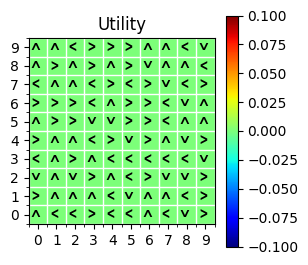

In [ ]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

In [ ]:
import time

def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    return result, execution_time

In [ ]:
class QLearningAgent:
    def __init__(self, mdp, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.mdp = mdp
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((len(mdp.S), len(mdp.A)))  # Initialize Q-values

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:  # Exploration
            return np.random.choice(len(self.mdp.A))
        else:  # Exploitation
            return np.argmax(self.Q[state])

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.Q[next_state])
        td_target = reward + self.gamma * self.Q[next_state, best_next_action]
        td_delta = td_target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_delta

def q_learning(mdp, num_episodes=1000):
    agent = QLearningAgent(mdp)
    rewards = []

    for episode in range(num_episodes):
        state = np.random.choice(mdp.S)  # Start from a random state
        total_reward = 0

        while True:
            action = agent.choose_action(state)
            reward = mdp.R[state]
            next_state = np.random.choice(mdp.nextStates[state][action])  # Sample next state

            agent.learn(state, action, reward, next_state)
            total_reward += reward
            state = next_state

            if state in mdp.terminal_states:  # Check if it's a terminal state
                break

        rewards.append(total_reward)

    return agent.Q, rewards


In [ ]:
def qLearning(mdp, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((len(mdp.S), len(mdp.A)))  # Initialize Q-values

    for episode in range(num_episodes):
        state = np.random.choice(mdp.S)  # Start from a random state
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(np.arange(len(mdp.A)))  # Ensure action is valid
            else:
                action = np.argmax(Q[state, :])  # Choose best action based on current Q-values

            # Transition logic and reward collection
            new_state = np.random.choice(mdp.S, p=mdp.T[state, action, :])  # Sample next state based on transition
            reward = mdp.R[state, action]

            # Q-value update
            Q[state, action] += alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

            # Check for terminal state
            if new_state in mdp.terminal_states:
                done = True

            state = new_state

    return Q

Q = qLearning(mdp, num_episodes=1, alpha=0.1, gamma=0.99, epsilon=0.1)


def f_qlearning(numEpisodes=1):
    start_time = timeit.default_timer()
    # Run Q-learning for numEpisodes
    Q = qLearning(mdp, num_episodes=numEpisodes, alpha=0.1, gamma=0.99, epsilon=0.1)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed * 1000, 2))

    # Derive policy from Q-values
    policy = np.argmax(Q, axis=1)  # Greedy policy based on max Q-value for each state

    # Plot the learned policy
    pl.figure(figsize=(3,3))
    value = np.max(Q, axis=1)  # Maximum Q-value per state
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10, 10), title='Utility (Q-Learning)', cmap='jet')

    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m = '\u02C2'
        elif policy[s] == 1:
            m = '\u02C3'
        elif policy[s] == 2:
            m = '\u02C4'
        elif policy[s] == 3:
            m = '\u02C5'
        pl.text(x - 0.5, y - 1, m, color='k', size=20)
    pl.show()

# Interactive widget for Q-learning
interactive_plot_qlearning = interactive(f_qlearning, numEpisodes=widgets.IntSlider(min=1, max=1000, step=50, value=100))
interactive_plot_qlearning


interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed